# Read GNSS Zenith Wet Delay (ZWD) data and convert to Integrated Water Vapour (IWV)

Use PPP output from https://webapp.csrs-scrs.nrcan-rncan.gc.ca/geod/tools-outils/ppp.php and convert ZWD to IWV.

Relevant scientific papers describing the approach:
https://agupubs.onlinelibrary.wiley.com/doi/10.1029/92JD01517
https://www.mdpi.com/2072-4292/14/21/5427
https://www.mdpi.com/2072-4292/14/5/1086

Use temperature data of local climate station to improve conversion.

In [1]:
import numpy as np
import pandas as pd
import os, glob, tqdm
import matplotlib.pyplot as plt
from pytz import timezone

from matplotlib.dates import DateFormatter
from matplotlib.dates import AutoDateLocator
from matplotlib import dates
import matplotlib.dates as mdates
from dateutil.tz import gettz


## Loading local climate data

In [2]:
filename='npa1_5min_climate_data.csv.gz'
npa1_climdata = pd.read_csv(filename)
npa1_climdata['DateTime'] = pd.to_datetime(npa1_climdata.DateTime)
npa1_climdata.set_index('DateTime', inplace=True)
npa1_climdata.head()

,P_hpa,T_C,rh,rh_1day_rolling_average,P_hpa_1day_rolling_average,T_C_1day_rolling_average
DateTime,,,,,,
2023-05-12 00:00:00+00:00,1013.1,24.8,27.9,27.9,1013.100,24.80
2023-05-12 00:05:00+00:00,1013.1,24.8,27.9,27.9,1013.100,24.80
2023-05-12 00:10:00+00:00,1013.1,24.8,27.9,27.9,1013.100,24.80
2023-05-12 00:15:00+00:00,1013.0,24.8,27.9,27.9,1013.075,24.80
2023-05-12 00:20:00+00:00,1013.0,24.9,27.9,27.9,1013.060,24.82


In [3]:
npa1_climdata.index

DatetimeIndex(['2023-05-12 00:00:00+00:00', '2023-05-12 00:05:00+00:00',
               '2023-05-12 00:10:00+00:00', '2023-05-12 00:15:00+00:00',
               '2023-05-12 00:20:00+00:00', '2023-05-12 00:25:00+00:00',
               '2023-05-12 00:30:00+00:00', '2023-05-12 00:35:00+00:00',
               '2023-05-12 00:40:00+00:00', '2023-05-12 00:45:00+00:00',
               ...
               '2024-01-29 18:10:00+00:00', '2024-01-29 18:15:00+00:00',
               '2024-01-29 18:20:00+00:00', '2024-01-29 18:25:00+00:00',
               '2024-01-29 18:30:00+00:00', '2024-01-29 18:35:00+00:00',
               '2024-01-29 18:40:00+00:00', '2024-01-29 18:45:00+00:00',
               '2024-01-29 18:50:00+00:00', '2024-01-29 18:55:00+00:00'],
              dtype='datetime64[ns, UTC]', name='DateTime', length=58687, freq=None)

## Load GNSS converted ZWD

In [2]:
ls NPA1_PPP/*tro

NPA1_PPP/NPA100NEP_R_20232450000_05D_30S_MO.tro


In [5]:
npa_filelist = glob.glob('NPA1_PPP//NPA100NEP_R_20232450000_05D_30S_MO.tro')
npa_filelist.sort()

tro_columns=['SITE', 'EPOCH', 'TRODRY','TROWET', 'TROWET_sd', 'TGNTOT', 'TGNTOT_sd', 'TGETOT', 'TGETOT_sd']

npa1_list = []
print('reading csv files')
for i in tqdm.tqdm(range(len(npa_filelist))):
  npa1_tro_fn = npa_filelist[i]
  npa1_tro = pd.read_csv(npa1_tro_fn, delim_whitespace=True, low_memory=False, skip_blank_lines=True, skiprows=14, names=tro_columns, index_col=False)
  npa1_tro.dropna(inplace=True)

  #Simple fix to convert GNSS epochs to pandas datetime
  str_tro = npa1_tro["EPOCH"].values
  npa1_tro_GMT = [] #np.empty((len(str_tro),1), dtype=('datetime64'))
  for i in range(len(str_tro)):
    try:
        year=str(2000+int(str_tro[i].split(':')[0]))
    except AttributeError:
        continue
    doy=str_tro[i].split(':')[1]
    seconds=int(str_tro[i].split(':')[2])
    YDOY=pd.to_datetime(year +":"+ doy, format='%Y:%j', utc=True)
    npa1_tro_GMT.append(pd.to_datetime(YDOY) + pd.to_timedelta(seconds, unit='s'))
  npa1_tro['GMT'] = npa1_tro_GMT
  npa1_tro.drop(columns=['EPOCH'], inplace=True)
  npa1_tro.set_index('GMT', inplace=True)
  npa1_tro.head()
  npa1_list.append(npa1_tro)
# see pd.concat documentation for more info
npa1_tro_df = pd.concat(npa1_list)
# npa1_tro_df.to_hdf('NPA1_JJA2023.hdf', key='npa1_tro_df')


reading csv files


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


In [6]:
npa1_tro_df.head()

,SITE,TRODRY,TROWET,TROWET_sd,TGNTOT,TGNTOT_sd,TGETOT,TGETOT_sd
GMT,,,,,,,,
2023-09-02 00:00:00+00:00,NPA1,2205.4,327.4,14.8,0.0,1.3,0.0,1.3
2023-09-02 00:00:30+00:00,NPA1,2205.4,327.4,14.7,0.0,1.3,0.0,1.3
2023-09-02 00:01:00+00:00,NPA1,2205.7,327.6,14.6,0.0,1.3,0.0,1.3
2023-09-02 00:01:30+00:00,NPA1,2205.7,327.6,14.4,0.0,1.3,0.0,1.3
2023-09-02 00:02:00+00:00,NPA1,2205.7,327.6,14.3,0.0,1.3,0.0,1.3


In [7]:
npa1_tro_df.tail()

,SITE,TRODRY,TROWET,TROWET_sd,TGNTOT,TGNTOT_sd,TGETOT,TGETOT_sd
GMT,,,,,,,,
2023-09-06 23:57:30+00:00,NPA1,2203.8,278.1,13.3,0.5,1.2,0.4,1.4
2023-09-06 23:58:00+00:00,NPA1,2203.8,278.0,13.4,0.5,1.2,0.4,1.4
2023-09-06 23:58:30+00:00,NPA1,2203.8,278.0,13.6,0.5,1.2,0.4,1.4
2023-09-06 23:59:00+00:00,NPA1,2203.8,277.9,13.7,0.5,1.2,0.4,1.4
2023-09-06 23:59:30+00:00,NPA1,2203.7,277.8,13.8,0.5,1.2,0.4,1.4


In [8]:
npa1_tro_df['DOY'] = npa1_tro_df.index.dayofyear

In [9]:
npa1_tro_df.index

DatetimeIndex(['2023-09-02 00:00:00+00:00', '2023-09-02 00:00:30+00:00',
               '2023-09-02 00:01:00+00:00', '2023-09-02 00:01:30+00:00',
               '2023-09-02 00:02:00+00:00', '2023-09-02 00:02:30+00:00',
               '2023-09-02 00:03:00+00:00', '2023-09-02 00:03:30+00:00',
               '2023-09-02 00:04:00+00:00', '2023-09-02 00:04:30+00:00',
               ...
               '2023-09-06 23:55:00+00:00', '2023-09-06 23:55:30+00:00',
               '2023-09-06 23:56:00+00:00', '2023-09-06 23:56:30+00:00',
               '2023-09-06 23:57:00+00:00', '2023-09-06 23:57:30+00:00',
               '2023-09-06 23:58:00+00:00', '2023-09-06 23:58:30+00:00',
               '2023-09-06 23:59:00+00:00', '2023-09-06 23:59:30+00:00'],
              dtype='datetime64[ns, UTC]', name='GMT', length=14366, freq=None)

In [10]:
# drop string column of SITE name
npa1_tro_df.drop(columns='SITE', inplace=True)

# Clip out date range from longer climate time series

In [11]:
start_date='2023-09-02'
end_date = '2023-09-07'
mask = (npa1_climdata.index > start_date) & (npa1_climdata.index <= end_date)
npa1_climdata.loc[mask]

,P_hpa,T_C,rh,rh_1day_rolling_average,P_hpa_1day_rolling_average,T_C_1day_rolling_average
DateTime,,,,,,
2023-09-02 00:05:00+00:00,946.1,23.4,100.0,100.000000,945.599306,26.671181
2023-09-02 00:10:00+00:00,946.2,23.6,100.0,100.000000,945.596181,26.672222
2023-09-02 00:15:00+00:00,946.2,23.7,100.0,100.000000,945.593056,26.673264
2023-09-02 00:20:00+00:00,946.3,23.8,100.0,100.000000,945.590278,26.674653
2023-09-02 00:25:00+00:00,946.3,24.1,100.0,100.000000,945.587500,26.678819
...,...,...,...,...,...,...
2023-09-06 23:40:00+00:00,948.6,20.8,100.0,99.604514,946.369097,26.743750
2023-09-06 23:45:00+00:00,948.6,20.7,100.0,99.604514,946.374306,26.739931
2023-09-06 23:50:00+00:00,948.6,20.8,100.0,99.604514,946.379514,26.736458


# Plot Zenith Wet Delay and Climate Data

Text(0.5, 1.0, 'Station npa1, 5-minute logging interval, temperature')

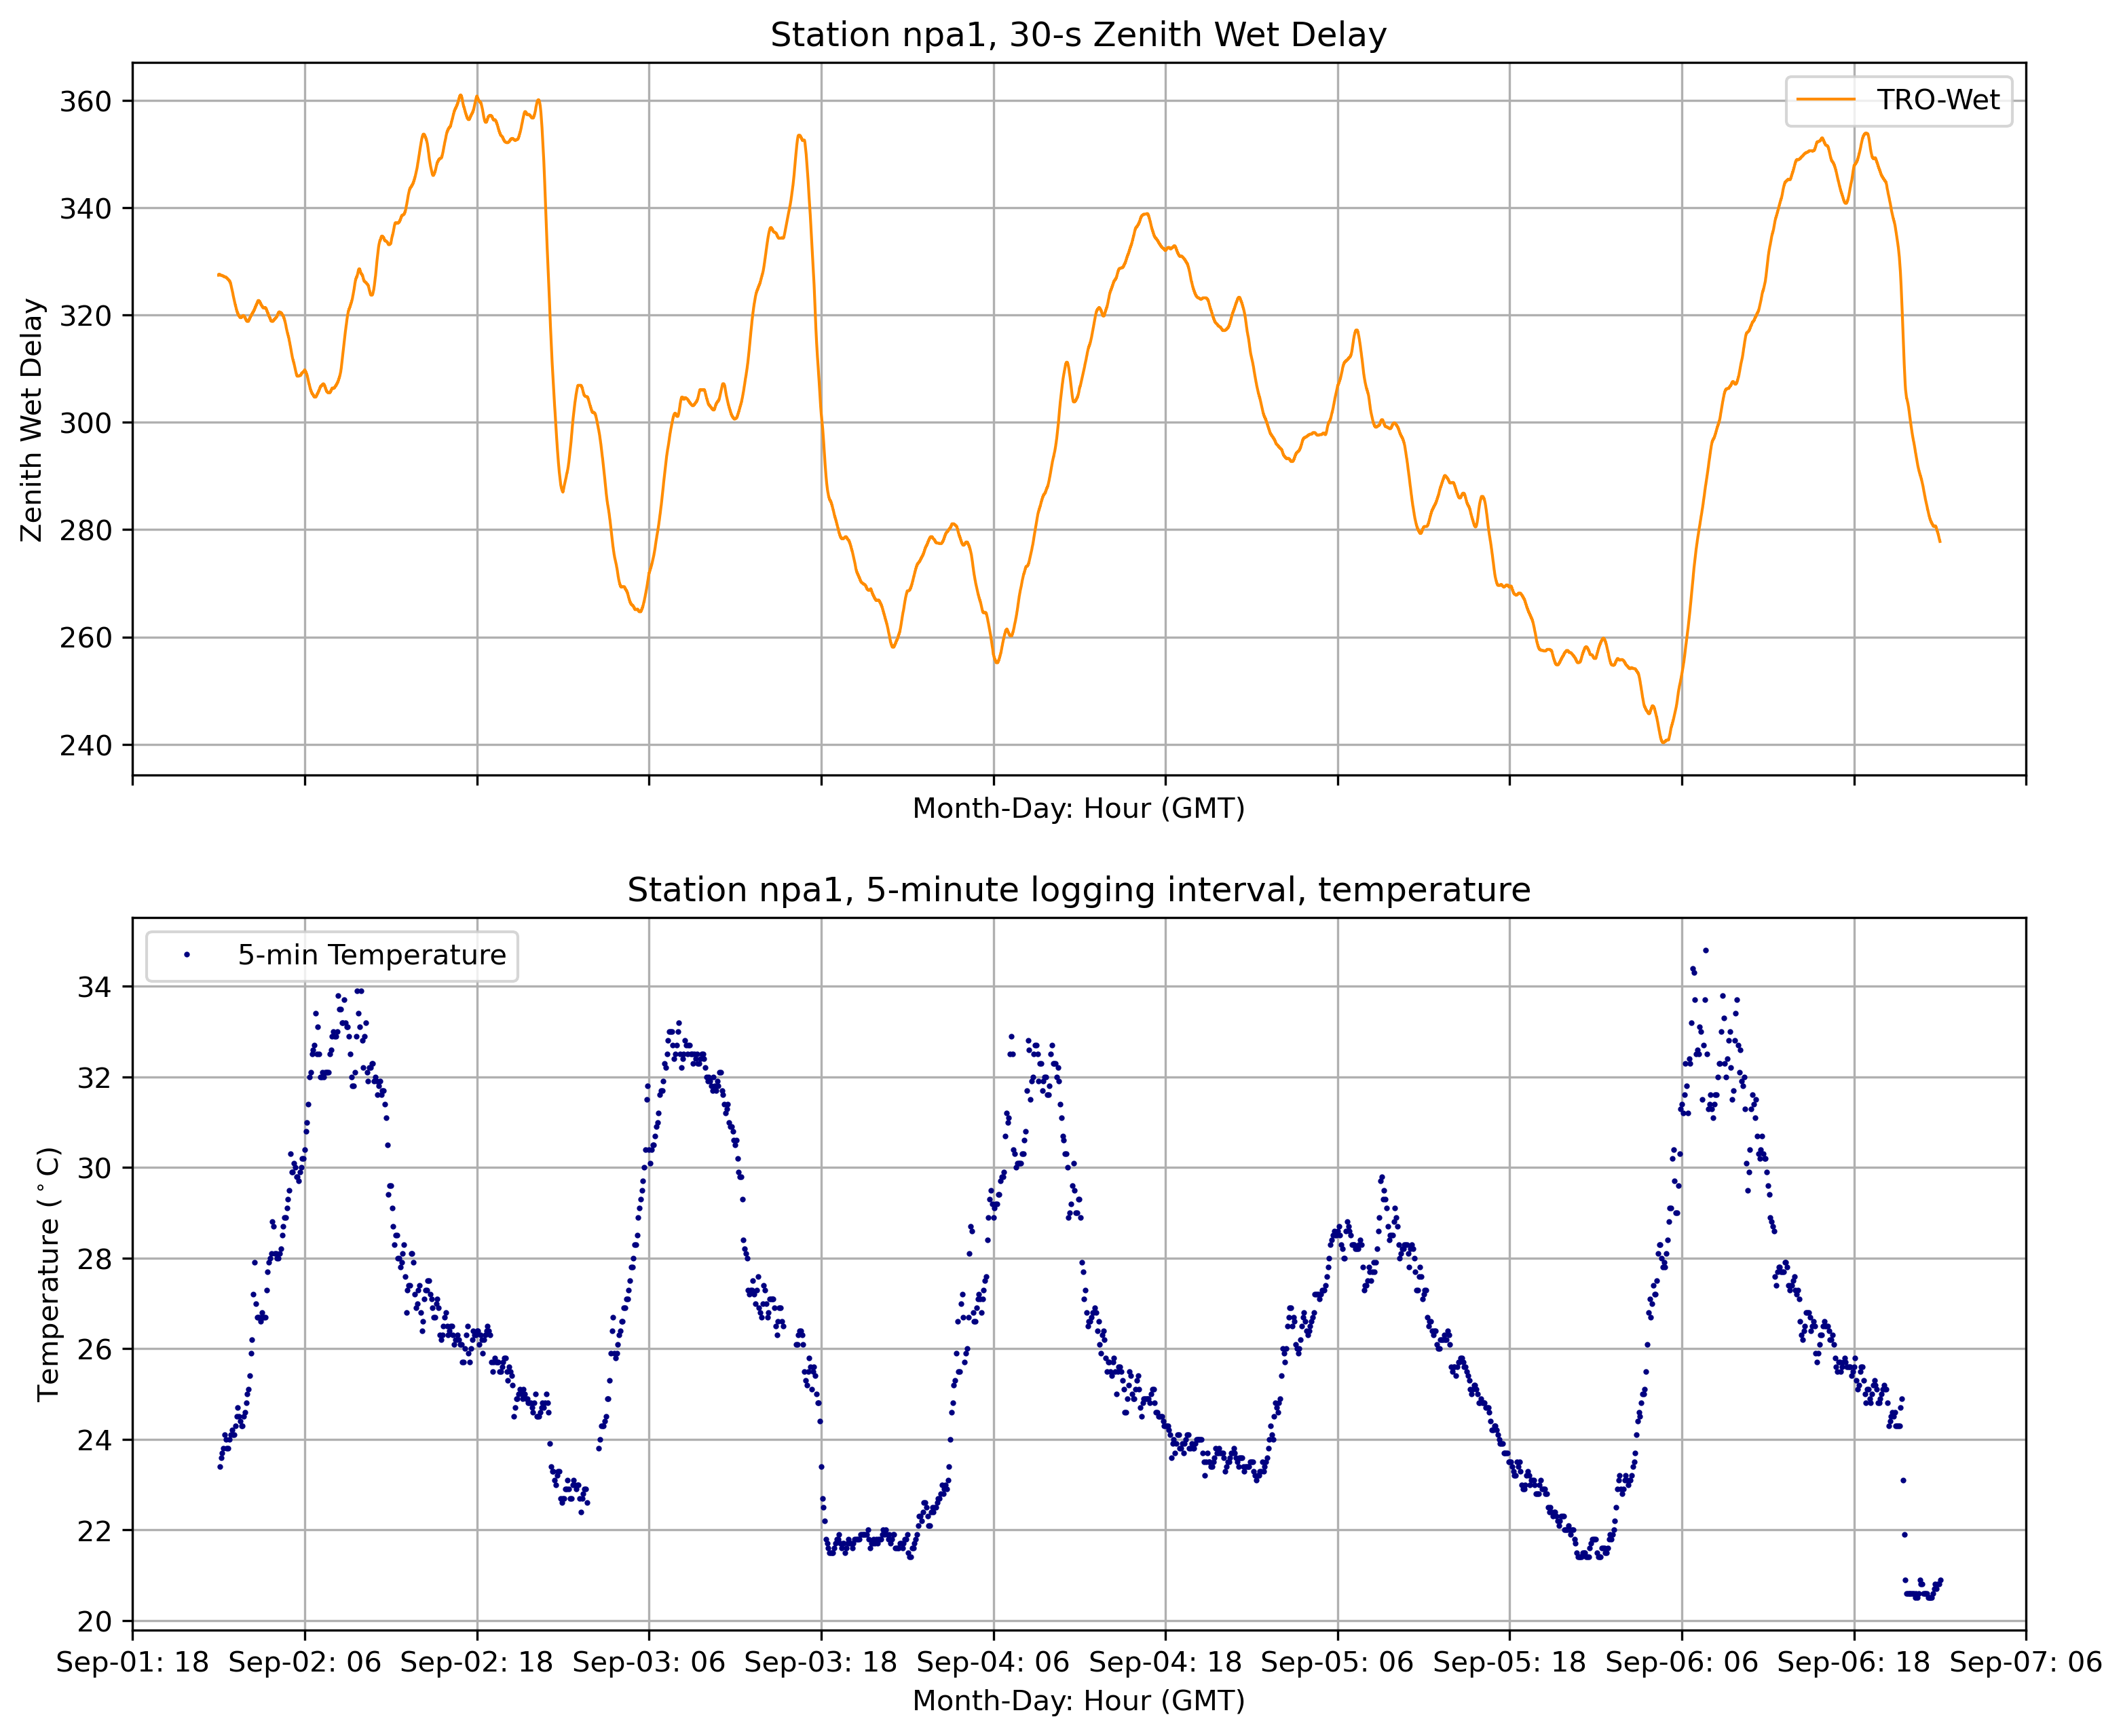

In [12]:
station_name = 'npa1'

fg, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,10), sharex=True, dpi=300)
ax[0].plot(npa1_tro_df.index, npa1_tro_df['TROWET'], linestyle='-', marker='', lw=1, color='darkorange', label='TRO-Wet')
ax[0].grid()
ax[0].set_xlabel('Month-Day: Hour (GMT)')
ax[0].set_ylabel('Zenith Wet Delay')
ax[0].legend()
date_form = DateFormatter("%b-%d: %H")
# date_form = DateFormatter('%d.%m.%Y')
# date_form.set_tzinfo(gettz('Asia/Kathmandu'));
date_form.set_tzinfo(gettz('GMT'));
ax[0].xaxis.set_major_formatter(date_form)
ax[0].xaxis.set_major_locator(mdates.HourLocator(interval=12))
ax[0].set_title('Station %s, 30-s Zenith Wet Delay'%station_name)

ax[1].plot(npa1_climdata.loc[mask].index, npa1_climdata.loc[mask]['T_C'], linestyle='', marker='o', ms=1, lw=1, color='navy', label='5-min Temperature')
# ax[1].plot(npa1_climdata.loc[mask].index, npa1_climdata.loc[mask]['T_C_1day_rolling_average'], marker='', ms=1, lw=1, linestyle='-', color='navy', label='Temperature 24-h rolling average')
ax[1].grid()
ax[1].set_xlabel('Month-Day: Hour (GMT)')
ax[1].set_ylabel('Temperature ($^\circ$C)')
ax[1].legend()
#date_form = DateFormatter("%b-%d")
# date_form = DateFormatter('%d.%m.%Y')
#date_form.set_tzinfo(gettz('Asia/Kolkata'));
date_form.set_tzinfo(gettz('GMT'));
ax[1].xaxis.set_major_formatter(date_form)
# ax[1].xaxis.set_major_locator(mdates.HourLocator(interval=24))

ax[1].set_title('Station %s, 5-minute logging interval, temperature'%station_name)


# Convert ZWD to Integrated Water Vapour using T from station data

PWV=Π⋅ZWDΠ=106⋅[(𝑘′2+𝑘3/𝑇𝑚)⋅𝑅𝑣⋅𝜌𝑤]−1
 
(1)where Π
 is the conversion factor, 𝑘′2
 and 𝑘3
 represent the atmospheric refraction constant with values of 22.1 k/mb and 373,900 k2/mb
, respectively [7], 𝑅𝑉
 is a constant with a value of 461.495 J⋅kg−1⋅K−1
, and 𝜌𝑤
 is the water vapour density (g/cm3). 𝑇𝑚
 represents the weighted average atmospheric temperature (unit: K). A linear relationship between the weighted average temperature and ground temperature was proposed by Bevis et al. [7,22,23] using radiosonde data over many years:
𝑇𝑚=70.2+0.72𝑇𝑠

In [17]:
k2 = 22.1 #k/mb
k3 = 373900 #k**2/mb
Rv = 461.495 # J*kg**-1 * K**-1
rw = 3.63e-3 #g/cm3 at 100C: 5.98 × 10–4 g cm–3
npa1_climdata['Tm'] = 70.2 + 0.72 * npa1_climdata['T_C']
npa1_climdata['ZWD_to_IWV'] = (k2 * (k3 / npa1_climdata['Tm'])) * Rv * rw * 1e-6

In [18]:
npa1_climdata['ZWD_to_IWV']

DateTime
2023-05-12 00:00:00+00:00    0.157204
2023-05-12 00:05:00+00:00    0.157204
2023-05-12 00:10:00+00:00    0.157204
2023-05-12 00:15:00+00:00    0.157204
2023-05-12 00:20:00+00:00    0.157075
                               ...   
2024-01-29 18:35:00+00:00    0.179347
2024-01-29 18:40:00+00:00    0.179347
2024-01-29 18:45:00+00:00    0.179180
2024-01-29 18:50:00+00:00    0.179347
2024-01-29 18:55:00+00:00    0.179850
Name: ZWD_to_IWV, Length: 58687, dtype: float64

## Clip data and resample to same time steps

In [19]:
npa1_climdata_sep2 = npa1_climdata.loc[mask]
npa1_climdata_sep2.head()

,P_hpa,T_C,rh,rh_1day_rolling_average,P_hpa_1day_rolling_average,T_C_1day_rolling_average,Tm,ZWD_to_IWV
DateTime,,,,,,,,
2023-09-02 00:05:00+00:00,946.1,23.4,100.0,100.0,945.599306,26.671181,87.048,0.159024
2023-09-02 00:10:00+00:00,946.2,23.6,100.0,100.0,945.596181,26.672222,87.192,0.158761
2023-09-02 00:15:00+00:00,946.2,23.7,100.0,100.0,945.593056,26.673264,87.264,0.158630
2023-09-02 00:20:00+00:00,946.3,23.8,100.0,100.0,945.590278,26.674653,87.336,0.158500
2023-09-02 00:25:00+00:00,946.3,24.1,100.0,100.0,945.587500,26.678819,87.552,0.158109


In [20]:
npa1_tro_df_5min = npa1_tro_df.resample('5min').mean()

In [21]:
npa1_tro_df_5min.head()

,TRODRY,TROWET,TROWET_sd,TGNTOT,TGNTOT_sd,TGETOT,TGETOT_sd,DOY
GMT,,,,,,,,
2023-09-02 00:00:00+00:00,2205.62,327.54,14.25,0.0,1.30,0.0,1.30,245.0
2023-09-02 00:05:00+00:00,2205.60,327.45,13.15,0.0,1.30,0.0,1.30,245.0
2023-09-02 00:10:00+00:00,2205.65,327.39,12.18,0.0,1.30,0.0,1.30,245.0
2023-09-02 00:15:00+00:00,2205.70,327.30,11.44,0.0,1.23,0.0,1.24,245.0
2023-09-02 00:20:00+00:00,2205.70,327.17,10.95,0.0,1.20,0.0,1.20,245.0


In [22]:
npa1_tro_df_5min = npa1_tro_df_5min.merge(npa1_climdata['ZWD_to_IWV'], left_index=True, right_index=True, how='left')
npa1_tro_df_5min.head()

,TRODRY,TROWET,TROWET_sd,TGNTOT,TGNTOT_sd,TGETOT,TGETOT_sd,DOY,ZWD_to_IWV
GMT,,,,,,,,,
2023-09-02 00:00:00+00:00,2205.62,327.54,14.25,0.0,1.30,0.0,1.30,245.0,0.158893
2023-09-02 00:05:00+00:00,2205.60,327.45,13.15,0.0,1.30,0.0,1.30,245.0,0.159024
2023-09-02 00:10:00+00:00,2205.65,327.39,12.18,0.0,1.30,0.0,1.30,245.0,0.158761
2023-09-02 00:15:00+00:00,2205.70,327.30,11.44,0.0,1.23,0.0,1.24,245.0,0.158630
2023-09-02 00:20:00+00:00,2205.70,327.17,10.95,0.0,1.20,0.0,1.20,245.0,0.158500


In [23]:
npa1_tro_df_5min['IWV'] = npa1_tro_df_5min['ZWD_to_IWV'] * npa1_tro_df_5min['TROWET']

## Plot

Text(0.5, 1.0, 'Station npa1, 5-min Integrated Water Vapour')

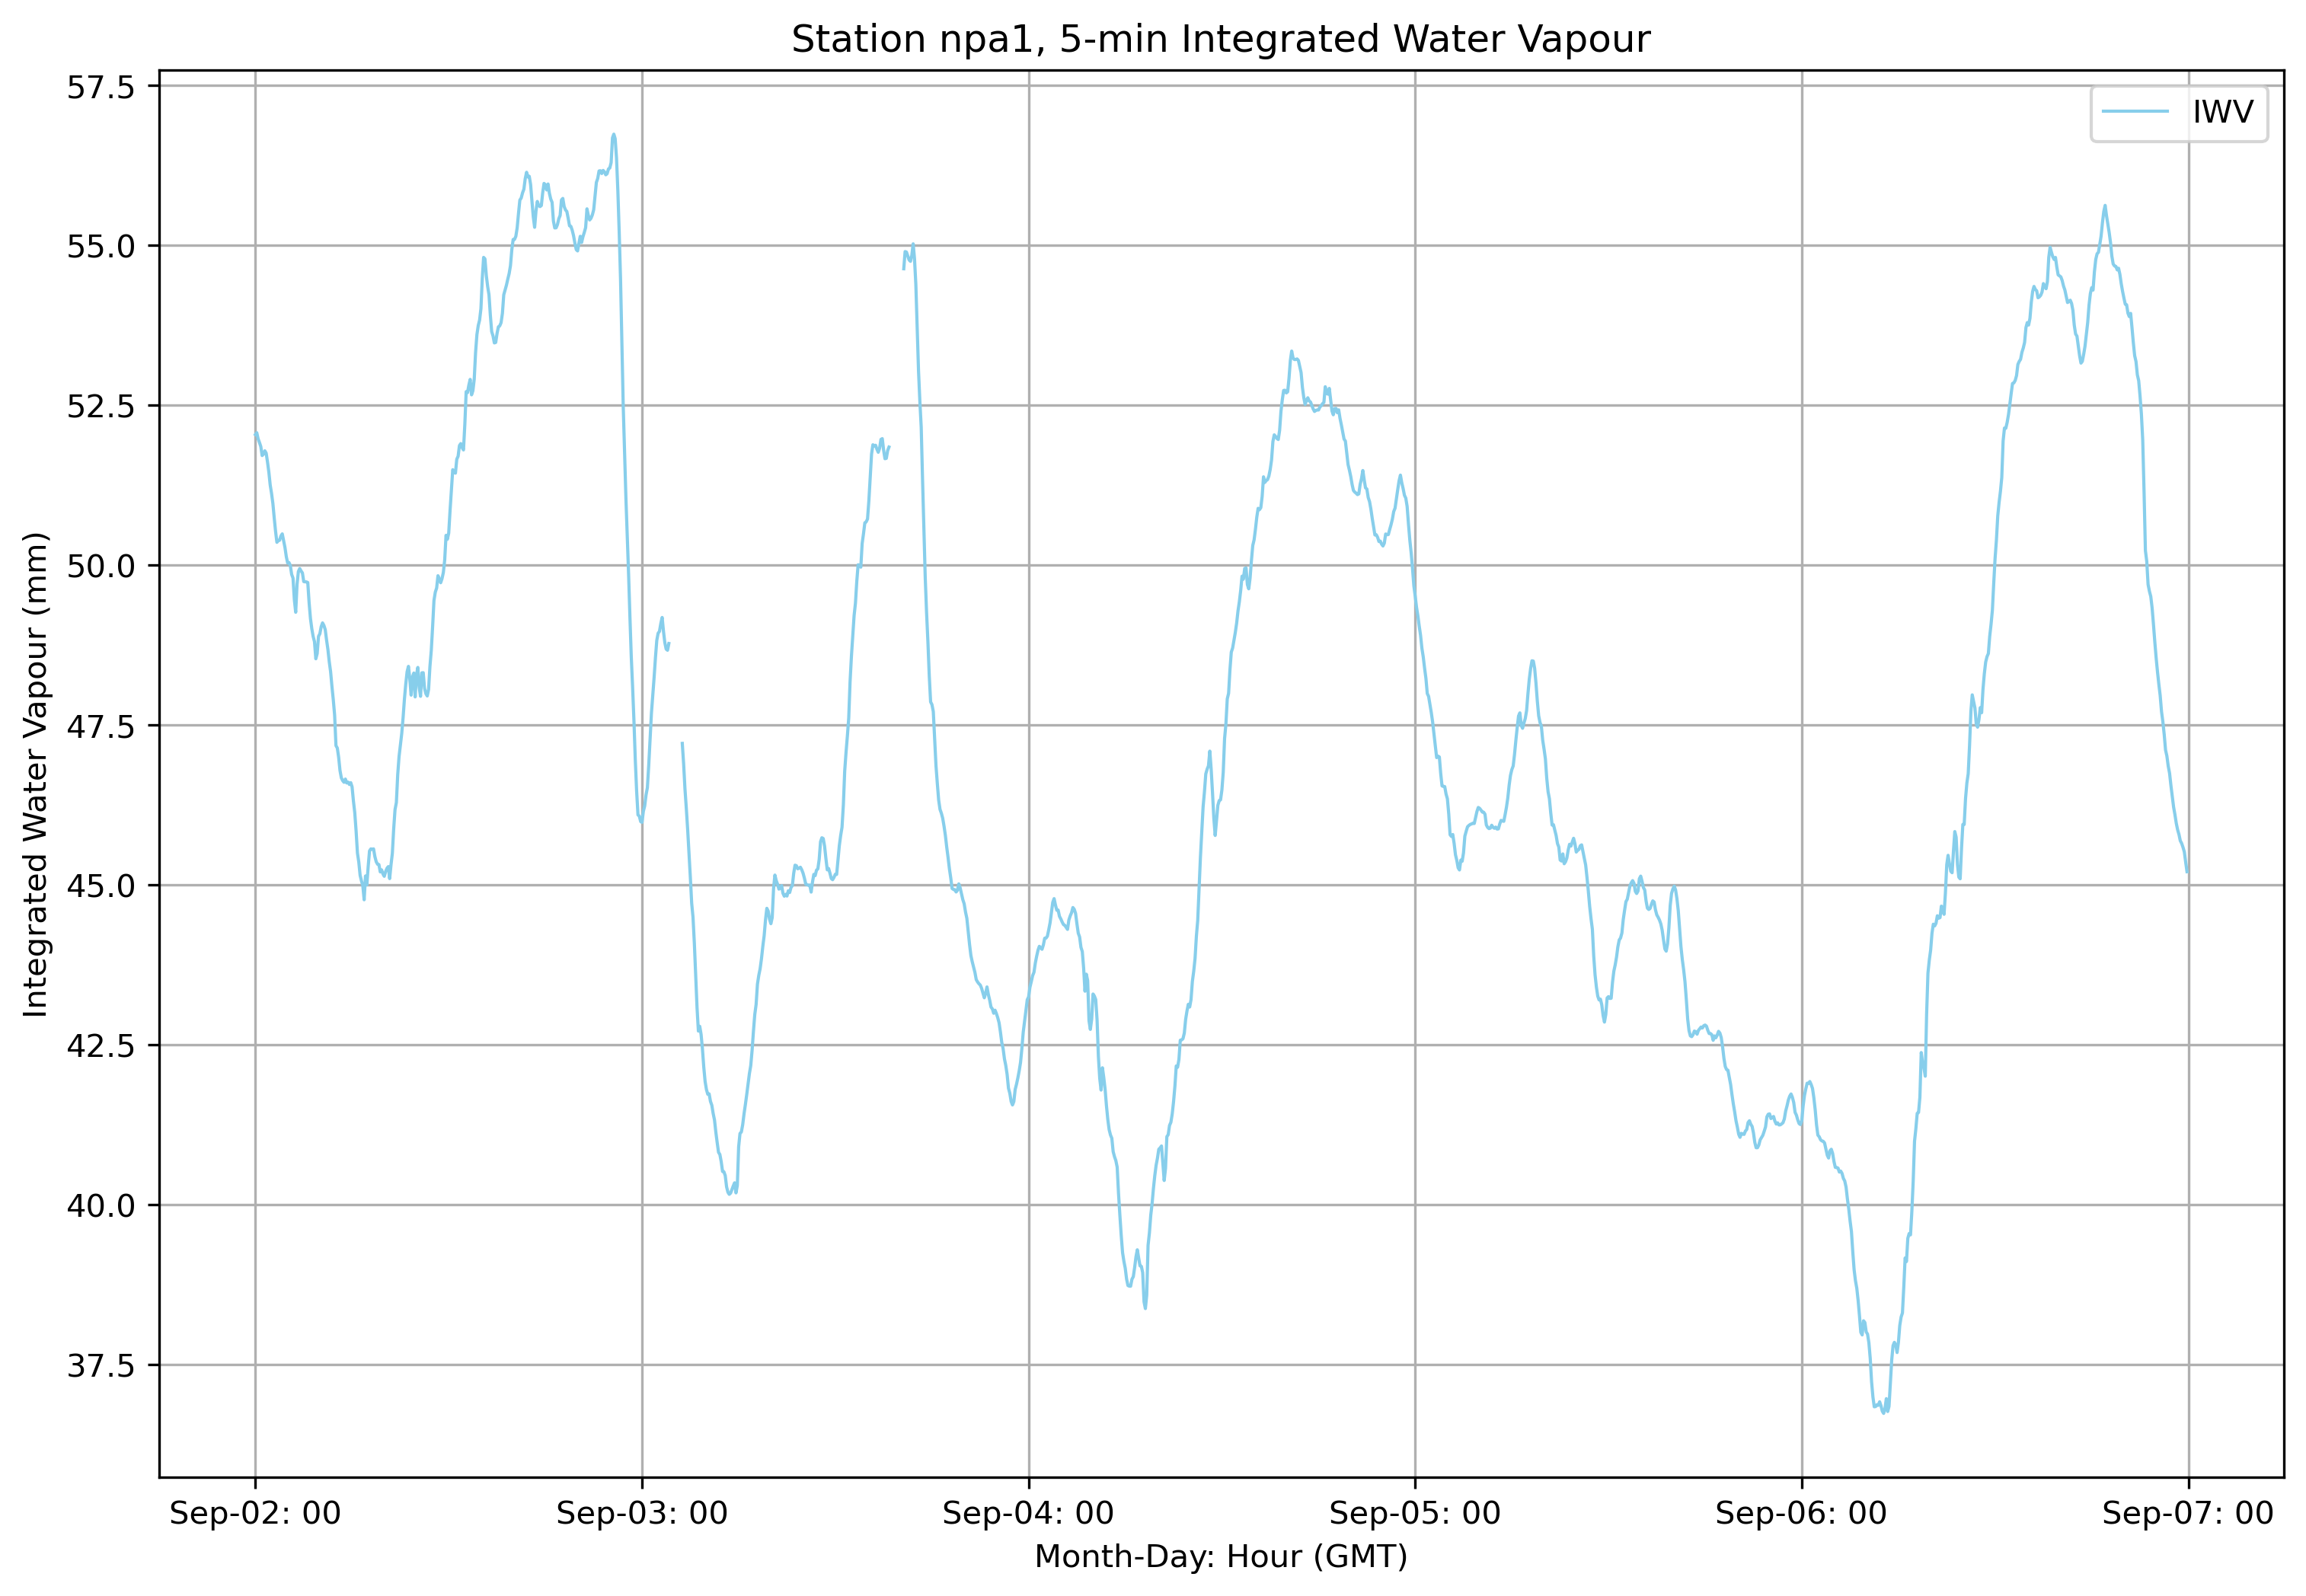

In [40]:
fg, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8), sharex=True, dpi=300)
ax.plot(npa1_tro_df_5min.index, npa1_tro_df_5min['IWV'], linestyle='-', marker='', lw=1, color='skyblue', label='IWV')
ax.grid()
ax.set_xlabel('Month-Day: Hour (GMT)')
ax.set_ylabel('Integrated Water Vapour (mm)')
ax.legend()
date_form = DateFormatter("%b-%d: %H")
# date_form = DateFormatter('%d.%m.%Y')
# date_form.set_tzinfo(gettz('Asia/Kathmandu'));
date_form.set_tzinfo(gettz('GMT'));
ax.xaxis.set_major_formatter(date_form)
ax.set_title('Station %s, 5-min Integrated Water Vapour'%station_name)

# Repeat analysis for NPA3 station

In [30]:
filename='npa3_5min_climate_data.csv.gz'
npa3_climdata = pd.read_csv(filename)
npa3_climdata['DateTime'] = pd.to_datetime(npa3_climdata.DateTime)
npa3_climdata.set_index('DateTime', inplace=True)
npa3_climdata.head()

,P_hpa,T_C,rh,rh_1day_rolling_average,P_hpa_1day_rolling_average,T_C_1day_rolling_average
DateTime,,,,,,
2023-05-12 00:00:00+00:00,1013.1,25.7,27.7,27.70,1013.1,25.7
2023-05-12 00:05:00+00:00,1013.1,25.7,27.7,27.70,1013.1,25.7
2023-05-12 00:10:00+00:00,1013.1,25.7,27.7,27.70,1013.1,25.7
2023-05-12 00:15:00+00:00,1013.1,25.7,27.7,27.70,1013.1,25.7
2023-05-12 00:20:00+00:00,1013.1,25.7,27.8,27.72,1013.1,25.7


In [27]:
npa_filelist = glob.glob('NPA3_PPP/NPA300NEP_R_20232450000_05D_30S_MO.tro')
npa_filelist.sort()

tro_columns=['SITE', 'EPOCH', 'TRODRY','TROWET', 'TROWET_sd', 'TGNTOT', 'TGNTOT_sd', 'TGETOT', 'TGETOT_sd']

npa3_list = []
print('reading csv files')
for i in tqdm.tqdm(range(len(npa_filelist))):
  npa3_tro_fn = npa_filelist[i]
  npa3_tro = pd.read_csv(npa3_tro_fn, delim_whitespace=True, low_memory=False, skip_blank_lines=True, skiprows=14, names=tro_columns, index_col=False)
  npa3_tro.dropna(inplace=True)

  #Simple fix to convert GNSS epochs to pandas datetime
  str_tro = npa3_tro["EPOCH"].values
  npa3_tro_GMT = [] #np.empty((len(str_tro),1), dtype=('datetime64'))
  for i in range(len(str_tro)):
    try:
        year=str(2000+int(str_tro[i].split(':')[0]))
    except AttributeError:
        continue
    doy=str_tro[i].split(':')[1]
    seconds=int(str_tro[i].split(':')[2])
    YDOY=pd.to_datetime(year +":"+ doy, format='%Y:%j', utc=True)
    npa3_tro_GMT.append(pd.to_datetime(YDOY) + pd.to_timedelta(seconds, unit='s'))
  npa3_tro['GMT'] = npa3_tro_GMT
  npa3_tro.drop(columns=['EPOCH'], inplace=True)
  npa3_tro.set_index('GMT', inplace=True)
  npa3_tro.head()
  npa3_list.append(npa3_tro)
# see pd.concat documentation for more info
npa3_tro_df = pd.concat(npa3_list)

npa3_tro_df['DOY'] = npa3_tro_df.index.dayofyear
# drop string column of SITE name
npa3_tro_df.drop(columns='SITE', inplace=True)
npa3_tro_df.head()

reading csv files


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


,TRODRY,TROWET,TROWET_sd,TGNTOT,TGNTOT_sd,TGETOT,TGETOT_sd,DOY
GMT,,,,,,,,
2023-09-02 00:00:00+00:00,1912.0,195.0,14.6,1.1,1.5,1.2,1.5,245
2023-09-02 00:00:30+00:00,1912.0,195.0,14.5,1.1,1.5,1.2,1.5,245
2023-09-02 00:01:00+00:00,1911.8,195.0,14.4,1.1,1.5,1.2,1.5,245
2023-09-02 00:01:30+00:00,1911.8,195.0,14.3,1.1,1.5,1.2,1.5,245
2023-09-02 00:02:00+00:00,1911.8,195.0,14.2,1.1,1.5,1.2,1.5,245


In [31]:
#Clip out date range
start_date='2023-09-02'
end_date = '2023-09-07'
mask = (npa3_climdata.index > start_date) & (npa3_climdata.index <= end_date)
npa3_climdata.loc[mask]

,P_hpa,T_C,rh,rh_1day_rolling_average,P_hpa_1day_rolling_average,T_C_1day_rolling_average
DateTime,,,,,,
2023-09-02 00:05:00+00:00,824.2,16.7,100.0,99.986347,823.964207,20.478598
2023-09-02 00:10:00+00:00,824.2,16.8,100.0,99.986347,823.961624,20.474170
2023-09-02 00:15:00+00:00,824.2,16.9,100.0,99.986347,823.959041,20.470111
2023-09-02 00:20:00+00:00,824.3,16.8,100.0,99.986347,823.956458,20.464945
2023-09-02 00:25:00+00:00,824.4,16.7,100.0,99.986347,823.954244,20.459779
...,...,...,...,...,...,...
2023-09-06 23:40:00+00:00,826.3,16.5,100.0,99.958667,824.972000,19.909778
2023-09-06 23:45:00+00:00,826.2,16.5,100.0,99.958667,824.974222,19.917333
2023-09-06 23:50:00+00:00,826.2,16.5,100.0,99.958667,824.976889,19.923556


In [36]:
# Convert to IWV
npa3_climdata['Tm'] = 70.2 + 0.72 * npa3_climdata['T_C']
npa3_climdata['ZWD_to_IWV'] = (k2 * (k3 / npa3_climdata['Tm'])) * Rv * rw * 1e-6

In [37]:
npa3_tro_df_5min = npa3_tro_df.resample('5min').mean()

In [38]:
npa3_tro_df_5min = npa3_tro_df_5min.merge(npa3_climdata['ZWD_to_IWV'], left_index=True, right_index=True, how='left')
npa3_tro_df_5min['IWV'] = npa3_tro_df_5min['ZWD_to_IWV'] * npa3_tro_df_5min['TROWET']
npa3_tro_df_5min.head()

,TRODRY,TROWET,TROWET_sd,TGNTOT,TGNTOT_sd,TGETOT,TGETOT_sd,DOY,ZWD_to_IWV,IWV
GMT,,,,,,,,,,
2023-09-02 00:00:00+00:00,1911.84,195.00,14.10,1.1,1.50,1.2,1.50,245.0,0.168354,32.828979
2023-09-02 00:05:00+00:00,1911.76,194.88,13.20,1.1,1.50,1.2,1.50,245.0,0.168354,32.808776
2023-09-02 00:10:00+00:00,1911.82,194.55,12.56,1.1,1.50,1.2,1.50,245.0,0.168206,32.724564
2023-09-02 00:15:00+00:00,1911.90,194.26,12.11,1.1,1.50,1.2,1.46,245.0,0.168059,32.647222
2023-09-02 00:20:00+00:00,1911.97,194.08,11.75,1.1,1.47,1.2,1.40,245.0,0.168206,32.645507


# Plot NPA1 and NPA3

Text(0.5, 1.0, 'Station NPA1 and NPA3, 5-min Integrated Water Vapour')

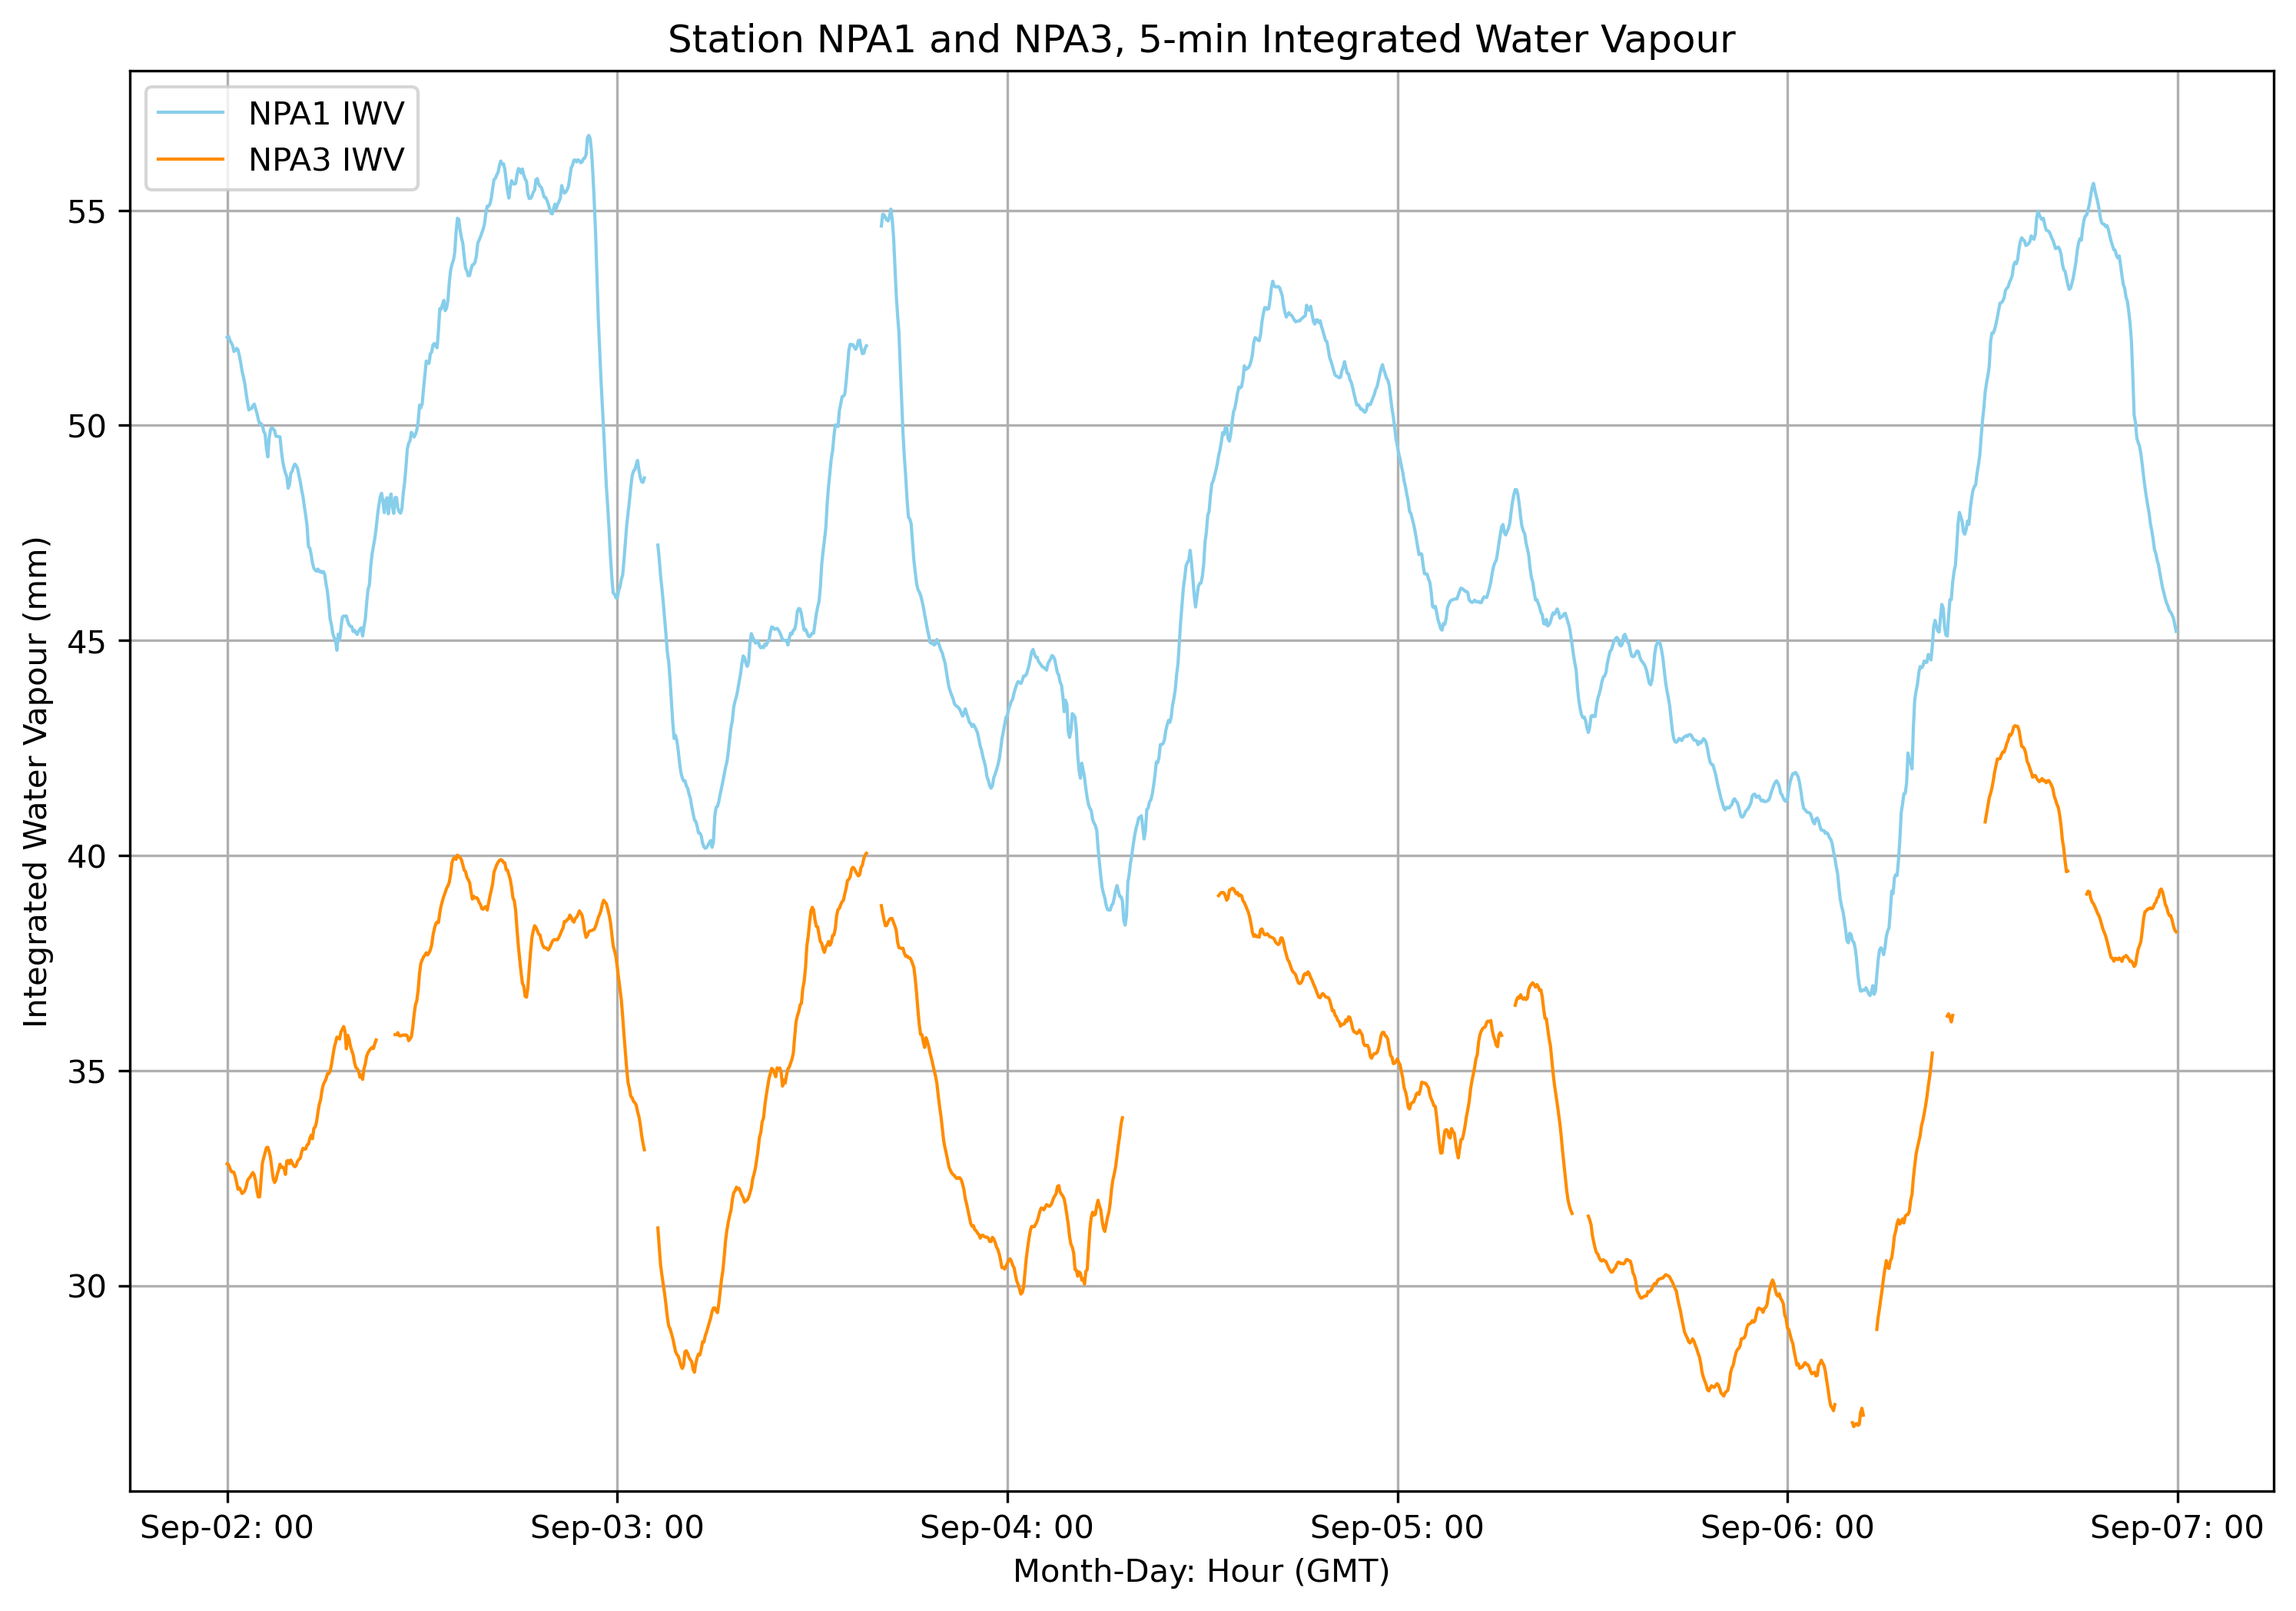

In [41]:
fg, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8), sharex=True, dpi=300)
ax.plot(npa1_tro_df_5min.index, npa1_tro_df_5min['IWV'], linestyle='-', marker='', lw=1, color='skyblue', label='NPA1 IWV')
ax.plot(npa3_tro_df_5min.index, npa3_tro_df_5min['IWV'], linestyle='-', marker='', lw=1, color='darkorange', label='NPA3 IWV')
ax.grid()
ax.set_xlabel('Month-Day: Hour (GMT)')
ax.set_ylabel('Integrated Water Vapour (mm)')
ax.legend()
date_form = DateFormatter("%b-%d: %H")
# date_form = DateFormatter('%d.%m.%Y')
# date_form.set_tzinfo(gettz('Asia/Kathmandu'));
date_form.set_tzinfo(gettz('GMT'));
ax.xaxis.set_major_formatter(date_form)
ax.set_title('Station NPA1 and NPA3, 5-min Integrated Water Vapour')
